If we consider the slightly more complex system:

A + cat <---> B -> C + cat

where labeled reaction A-d10 is added with a time delay.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.reset_orig()
%matplotlib inline

reactions = [
    ('k1', ['A', 'cat'], ['B'],),
    ('k-1', ['B'], ['A', 'cat'],),
    ('k2', ['B'], ['C', 'cat']),

    # labeled
    ('k1', ['A-d10', 'cat'], ['B-d10'],),
    ('k-1', ['B-d10'], ['A-d10', 'cat'],),
    ('k2', ['B-d10'], ['C-d10', 'cat'])
]

rate_constants_real = {'k1': 0.3, 'k-1': 0.05, 'k2': 0.5}
dilution_factor = 1 / 2
concentration_initial = {'A': 1, 'cat': 1 / 5}
concentration_labeled = {'A-d10': 1*dilution_factor}  # same concentration as diluted unlabeled catalyst
time_pre = np.linspace(0, 10, 50)
time_post = np.linspace(10, 90, 8 * 50)

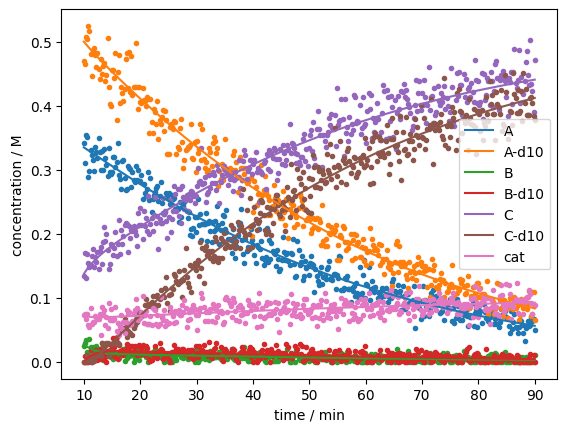

In [10]:
from delayed_reactant_labeling.predict import DRL
import polars as pl

drl_real = DRL(rate_constants=rate_constants_real, reactions=reactions)
real_data_pre, real_data = drl_real.predict_concentration(
    t_eval_pre=time_pre,
    t_eval_post=time_post,
    dilution_factor=dilution_factor,
    initial_concentrations=concentration_initial,
    labeled_concentration=concentration_labeled)

fig, ax = plt.subplots()

 # add noise
rng = np.random.default_rng(42)
fake_data = []
for col in real_data.columns[:-1]:  # last column contains time array
    noise_dynamic = real_data[col]**0.5 * rng.normal(loc=0, scale=0.04, size=(real_data.shape[0]))  # S/N increases with sqrt(I)
    noise_static = rng.normal(loc=0, scale=0.005, size=(real_data.shape[0]))
    fake_col = real_data[col] + noise_dynamic + noise_static  # noise is loosely based on intensity
    fake_col[fake_col < 1e-10] = 1e-10  # no negative intensity
    fake_data.append(fake_col)

    ax.plot(real_data['time'], real_data[col], label=col)
    ax.scatter(real_data['time'], fake_col, marker='.')

ax.legend()
ax.set_ylabel('concentration / M')
ax.set_xlabel('time / min')
fig.savefig('test.png')
fake_data.append(real_data['time'])
fake_data = pl.DataFrame(fake_data, real_data.columns)

In [ ]:
import pandas as pd
from delayed_reactant_labeling.optimize import RateConstantOptimizerTemplate

class RateConstantOptimizer(RateConstantOptimizerTemplate):
    @staticmethod
    def create_prediction(x: np.ndarray, x_description: list[str]) -> pl.DataFrame:
        # this is also the location where the rate constants can be manipulated easily
        # e.g. rate_constants['k1'] = 0.1, would fixate this value

        rate_constants = pd.Series(x, x_description)
        drl = DRL(reactions=reactions, rate_constants=rate_constants)
        _, pred_labeled = drl.predict_concentration(
            t_eval_pre=time_pre,
            t_eval_post=time_post,
            initial_concentrations=concentration_initial,
            labeled_concentration=concentration_labeled,
            dilution_factor=dilution_factor,
            rtol=1e-8,
            atol=1e-8, )

        # the output can also be manipulated before analyzing it further. Allows grouping of certain groups,
        # when we know that they are measured as the same compound in the mass spectrometer.
        return pred_labeled

    @staticmethod
    def calculate_curves(data: pl.DataFrame) -> dict[str, pl.Series]:
        curves = {}
        for chemical in ['A', 'B', 'C']:
            chemical_sum = data[[chemical, f'{chemical}-d10']].sum(axis=1)
            curves[f'ratio_{chemical}'] = data[chemical] / chemical_sum
        return curves

In [ ]:
def METRIC(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.average(np.abs(y_pred - y_true), axis=0)

RCO = RateConstantOptimizer(raw_weights={}, experimental=fake_data, metric=METRIC)
dimension_description = ['k1', 'k-1', 'k2']
bounds = [(1e-9, 100),    # k1
          (0,    100),    # k-1
          (1e-9, 100),]   # k2

path = 'optimization/example_optimize_simple_singular/'
RCO.optimize(
    path=path,
    x0=[5, 5, 5],
    x_bounds=bounds,
    x_description=dimension_description,
    maxiter=10000,
    _overwrite_log=True
)

In [ ]:
progress = RCO.load_optimization_progress(path)
pd.DataFrame([progress.best_X.values, np.array(list(rate_constants_real.values()))], index=['found', 'real'], columns=progress.best_X.index)

In [ ]:
fig, axs = plt.subplots(3, 1, tight_layout=True, figsize=(8, 8), squeeze=False)

true_curves = RCO.experimental_curves
best_pred = RCO.create_prediction(x=progress.best_X, x_description=progress.x_description)
errors = RCO.calculate_error_functions(best_pred)
errors = RCO.weigh_errors(errors)
pred_curves = RCO.calculate_curves(best_pred)

for i, chemical in enumerate(['A', 'B', 'C']):
        # plot label ratio
        axs[i, 0].plot(time_post, pred_curves[f"ratio_{chemical}"], color=f"C{i}",
                       label=f"{chemical} MAE: {errors[f'ratio_{chemical}']:.3f}")
        axs[i, 0].scatter(time_post, true_curves[f"ratio_{chemical}"],
                          color=f"C{i}", alpha=0.4, marker=".", s=1)

        # the curve of the labeled compound is the same, by definition, as 1 - unlabeled
        axs[i, 0].plot(time_post, 1 - pred_curves[f"ratio_{chemical}"], color="tab:gray")
        axs[i, 0].scatter(time_post, 1 - true_curves[f"ratio_{chemical}"], color="tab:gray", alpha=0.4, marker=".", s=1)
        axs[i, 0].legend()

In [ ]:
path_multiple = 'optimization/example_optimize_simple_multiple_loguniform/'
RCO.optimize_multiple(path=path_multiple, n_runs=500, x_bounds=bounds, x_description=dimension_description, n_jobs=-2)

In [ ]:
from delayed_reactant_labeling.visualize import VisualizeMultipleSolutions
VMS = VisualizeMultipleSolutions(path_multiple, max_guess=500)

In [ ]:
fig, ax = VMS.show_error_all_runs()
ax.set_ylabel("error")

eq = VMS.complete_found_error < 1.005 * VMS.complete_found_error.min()
ax_ins = ax.inset_axes([0.2, 0.57, 0.4, 0.4])
ax_ins.scatter(np.arange(sum(eq)), sorted(VMS.complete_found_error[eq]))
ax.indicate_inset_zoom(ax_ins, edgecolor='black')

In [ ]:
index_best_runs = np.argsort(VMS.complete_found_error)[:10]

best_runs = VMS.complete_found_error[index_best_runs]
best_X = VMS.complete_optimal_X[index_best_runs]

print(best_runs)

df = pd.DataFrame(
    best_X,
    columns=VMS.complete_all_X[0].columns
)
print(rate_constants_real)
df

In [ ]:
fig, ax = VMS.show_rate_constants(max_error=0.105, index_constant_values=None)
ax.set_yscale("linear")
ax.scatter([1, 2, 3], [0.3, 0.05, 0.5], label="true")
ax.legend()

In [ ]:
fig, axs = plt.subplots(3, 1, layout='tight', figsize=(8, 6))
for i in range(3):
    ax = axs[i]
    eq = np.where(VMS.complete_found_error < 0.105)
    best_X = VMS.complete_optimal_X[eq]
    sns.histplot(best_X[:, i], ax=ax)
    yl, yu = ax.get_ylim()
    k = list(rate_constants_real.values())[i]
    ax.plot([k, k], [yl, yu], label='true', color="tab:orange")
    ax.set_ylim(yl, yu)
    ax.set_title(VMS.x_description[i])

axs[0].legend()